In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/giasmp/GiaSmp.csv


In [2]:
import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv('/kaggle/input/giasmp/GiaSmp.csv', encoding = 'ISO-8859-1')
df.head(10)

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1/1/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,2/1/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,3/1/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,4/1/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,5/1/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
5,6/1/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
6,7/1/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
7,8/1/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
8,9/1/2021,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1,...,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1,1064.1
9,10/1/2021,966.7,966.7,966.7,966.7,966.7,966.7,966.7,966.7,966.7,...,966.8,966.8,966.8,966.8,966.8,966.8,966.7,966.7,966.7,966.7


In [4]:
df1 = pd.concat([df["Ngày"], df["34"], df['35'], df['36']], axis=1)
df1.head(10)

,Ngày,34,35,36
0,1/1/2021,964.4,964.4,964.4
1,2/1/2021,1019.7,1019.7,1019.7
2,3/1/2021,988.4,988.4,988.4
3,4/1/2021,1010.8,1010.8,1010.8
4,5/1/2021,1061.5,1061.5,1061.5
5,6/1/2021,1061.5,1061.5,1061.5
6,7/1/2021,1061.5,1061.5,1061.5
7,8/1/2021,1061.5,1061.5,1061.5
8,9/1/2021,1064.1,1064.1,1064.1
9,10/1/2021,966.8,966.8,966.8


2024-05-21 02:40:18.283645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 02:40:18.283778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 02:40:18.435586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


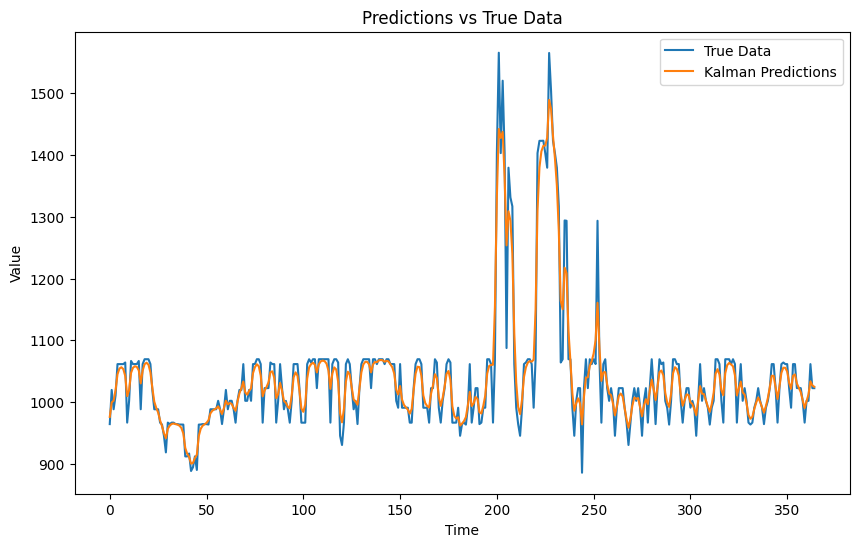

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
# Chọn cột chứa dữ liệu chuỗi thời gian
data_column = '34'

# Lấy dữ liệu từ cột đó
data = df1[data_column].values

# Chuẩn bị dữ liệu cho mô hình LSTM
seq_length = 10  # Độ dài của mỗi chuỗi đầu vào
X, Y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    Y.append(data[i+seq_length])
X = np.array(X)
Y = np.array(Y)
X = np.expand_dims(X, axis=-1)  # Thêm một chiều cho LSTM

# Tạo và huấn luyện mô hình LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=50, batch_size=16, verbose=0)

# Dự đoán với mô hình LSTM
lstm_predictions = model.predict(X)

# Dự đoán với bộ lọc Kalman
kf = KalmanFilter(initial_state_mean=data[0], n_dim_obs=1)
kalman_predictions = kf.smooth(data)[0]



# Trực quan hóa dữ liệu
plt.figure(figsize=(10, 6))
plt.plot(data, label='True Data')
plt.plot(kalman_predictions, label='Kalman Predictions')
plt.legend()
plt.title('Predictions vs True Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [6]:
msv = 2151264642
col1 = msv%16 + 1
col2 = msv%16 + 2
col3 = msv%16 + 3
dulieu = df[[str(col1),str(col2),str(col3)]]
dulieu.head(5)

,3,4,5
0,964.4,964.4,964.4
1,1019.7,1019.7,1019.7
2,988.4,988.4,988.4
3,1002.0,1002.0,1002.0
4,1061.5,1061.5,1061.5


In [7]:
dulieu['date'] = df['Ngày']

In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns

In [9]:
from pykalman import KalmanFilter

# Khởi tạo bộ lọc Kalman
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

In [10]:
# Áp dụng bộ lọc Kalman cho từng cột dữ liệu
dulieu[f'{col1}_kalman'] = kf.smooth(dulieu[str(col1)].values)[0]
dulieu[f'{col2}_kalman'] = kf.smooth(dulieu[str(col2)].values)[0]
dulieu[f'{col3}_kalman'] = kf.smooth(dulieu[str(col3)].values)[0]

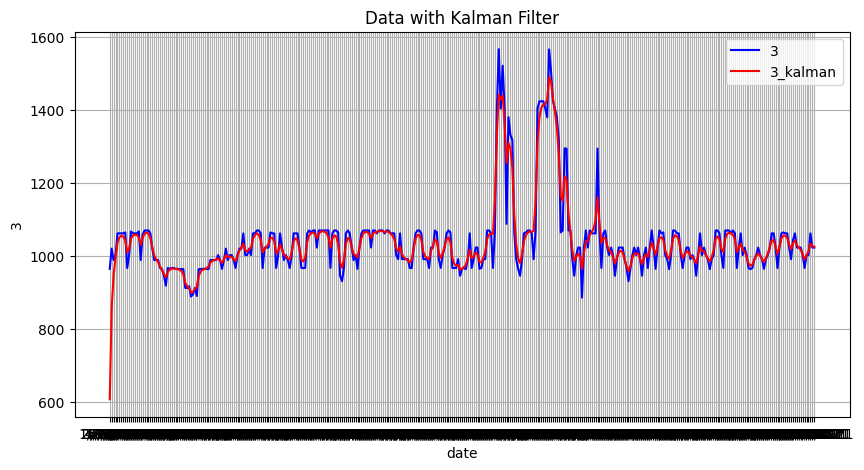

In [11]:
import numpy as np


# Trực quan hóa kết quả sau khi áp dụng bộ lọc Kalman
fig, ax = plt.subplots(figsize = (10,5))
sns.lineplot(ax=ax, data=dulieu, x="date", y=str(col1), label=col1, color ='b')
sns.lineplot(ax=ax, data=dulieu, x="date", y=f'{col1}_kalman', label=f'{col1}_kalman', color ='r')
plt.title('Data with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

ADF Statistic: -2.612344933766722
p-value: 0.0904725685085001


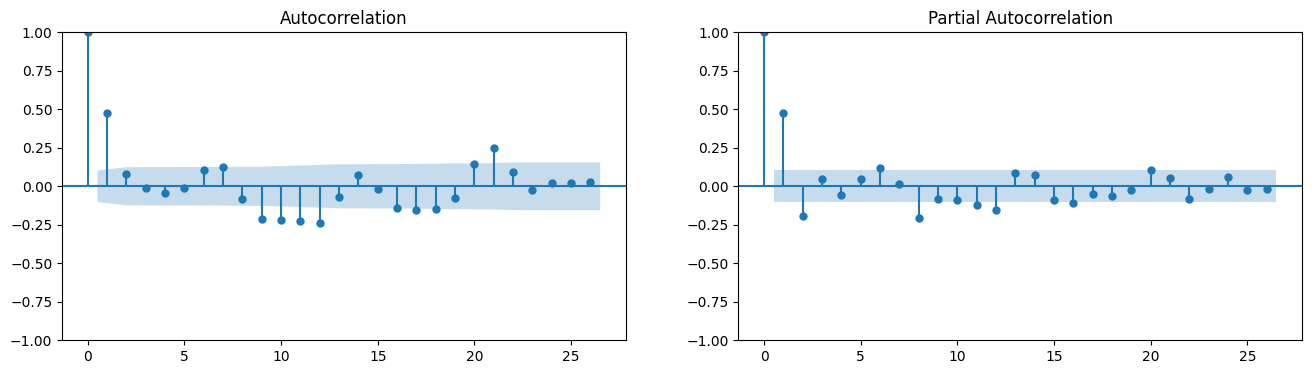

In [13]:
# Chọn một cột dữ liệu để dự đoán (ví dụ col1)
series = dulieu[f'{col1}_kalman']

# Kiểm tra tính dừng của dữ liệu bằng ADF test
result = adfuller(series.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# Nếu dữ liệu không dừng (p-value > 0.05), thực hiện vi phân
if result[1] > 0.05:
    series = series.diff().dropna()

# Xác định tham số p và q bằng ACF và PACF plots (có thể sử dụng visual inspection hoặc grid search)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(series, ax=axes[0])
plot_pacf(series, ax=axes[1])
plt.show()

In [14]:
# Khởi tạo và đào tạo mô hình ARIMA
model = ARIMA(series, order=(5, 1, 7))  # Thay đổi order nếu cần thiết
model_fit = model.fit()

# Tóm tắt mô hình
print(model_fit.summary())

# Dự báo
forecast_steps = 7  # Số bước dự báo
forecast = model_fit.forecast(steps=forecast_steps)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               3_kalman   No. Observations:                  364
Model:                 ARIMA(5, 1, 7)   Log Likelihood               -1668.062
Date:                Tue, 21 May 2024   AIC                           3362.124
Time:                        02:40:49   BIC                           3412.751
Sample:                             0   HQIC                          3382.248
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0177      0.123     -0.144      0.886      -0.259       0.224
ar.L2         -0.7085      0.108     -6.585      0.000      -0.919      -0.498
ar.L3         -0.4842      0.168     -2.880      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


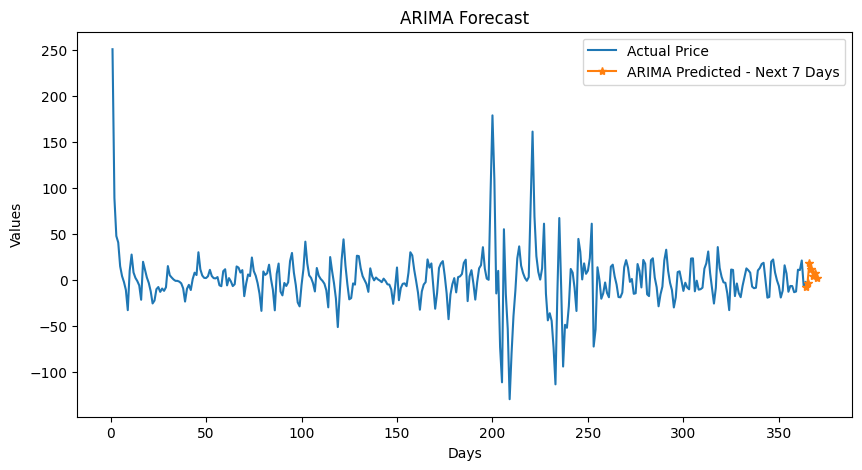

In [15]:
predicted_dates = np.arange(len(series), len(series) + len(forecast))

plt.figure(figsize=(10, 5))
plt.plot(series, label='Actual Price')
plt.plot(np.arange(len(series), len(series) + len(forecast)), forecast, label='ARIMA Predicted - Next 7 Days', marker='*')
plt.xlabel('Days')
plt.ylabel('Values')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()